<a href="https://colab.research.google.com/github/TaroTanakaa/MyFirstPullRequest/blob/master/Copy_of_COGS150Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COGS 150 Final
#Taro Tanaka | A16403932
3/18/24
Prof. Trott

#Are LLMS sensitive to offensive Language and profanity?



# Install and load transformers

In [1]:
%pip install transformers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!


# Tokenizations



In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

import torch
import transformers

gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")  # Load the model
gpt2.eval()  # Put the model in "evaluation mode" (as opposed to training mode).

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Probability Functions


In [3]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

# Calculating Surprisal


In [4]:
def surprisal(p):
  return -np.log2(p)

print(surprisal(1))
print(surprisal(.5))
print(surprisal(.001))

-0.0
1.0
9.965784284662087


#Defining Stimuli

In [5]:
stimuli = [
    ### sentence, word, condition, item number
    ('The situation was', ' challenging', 'Expected'),
    ('The situation was', ' fucked', 'Profane'),
    ('The weather was', ' unpredictable', 'Expected'),
    ('The weather was', ' shitty', 'Profane'),
    ('He stubbed his toe and shouted', ' ouch', 'Expected'),
    ('He stubbed his toe and shouted', ' fuck', 'Profane'),
    ('He spilled his coffee and muttered', ' ugh', 'Expected'),
    ('He spilled his coffee and muttered', ' damn', 'Profane'),
    ('The home team lost its soccer match, and one of the fans exclaimed ', ' bummer', 'Expected'),
    ('The home team lost its soccer match, and one of the fans exclaimed', ' bullshit', 'Profane'),
    ('She described her classmate as a ', ' friend', 'Expected'),
    ('She described her classmate as n ', ' jerk', 'Profane'),
    ('A child was doing something wrong so the mom said for him to take a ', ' walk', 'Expected'),
    ('A child was doing something wrong so the mom said for him to take a ', 'piss', 'Profane'),
    ('That guy is such a ', ' gentleman', 'Expected'),
    ('That guy is such a ', ' dick', 'Profane'),
    ('She exclaims, theres no way that story is true, ', ' lies', 'Expected'),
    ('She exclaims, theres no way that story is true, ', ' bollocks', 'Profane'),
    ('The student murmured, I missed the deadline, ', ' ugh', 'Expected'),
    ('The student murmered, I missed the deadline, ', ' damn', 'Profane'),
]


#Creating DataFrame


In [6]:
### Create DataFrame
df_stimuli = pd.DataFrame(stimuli, columns = ['Sentence', 'Word', 'Condition'])
df_stimuli.head(3)

,Sentence,Word,Condition
0,The situation was,challenging,Expected
1,The situation was,fucked,Profane
2,The weather was,unpredictable,Expected


#Calculate Surprisal

In [7]:
### Calculate surprisal
results = []
for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


#Create DataFrame

In [8]:
  ### Create DataFrame
df_results = pd.DataFrame(results)
df_results.head(2)

,Word,Sentence,Condition,Probability,Surprisal
0,challenging,The situation was,Expected,0.000372,11.391071
1,fucked,The situation was,Profane,0.000035,14.790296


#Visualze Results

<Axes: xlabel='Condition', ylabel='Surprisal'>

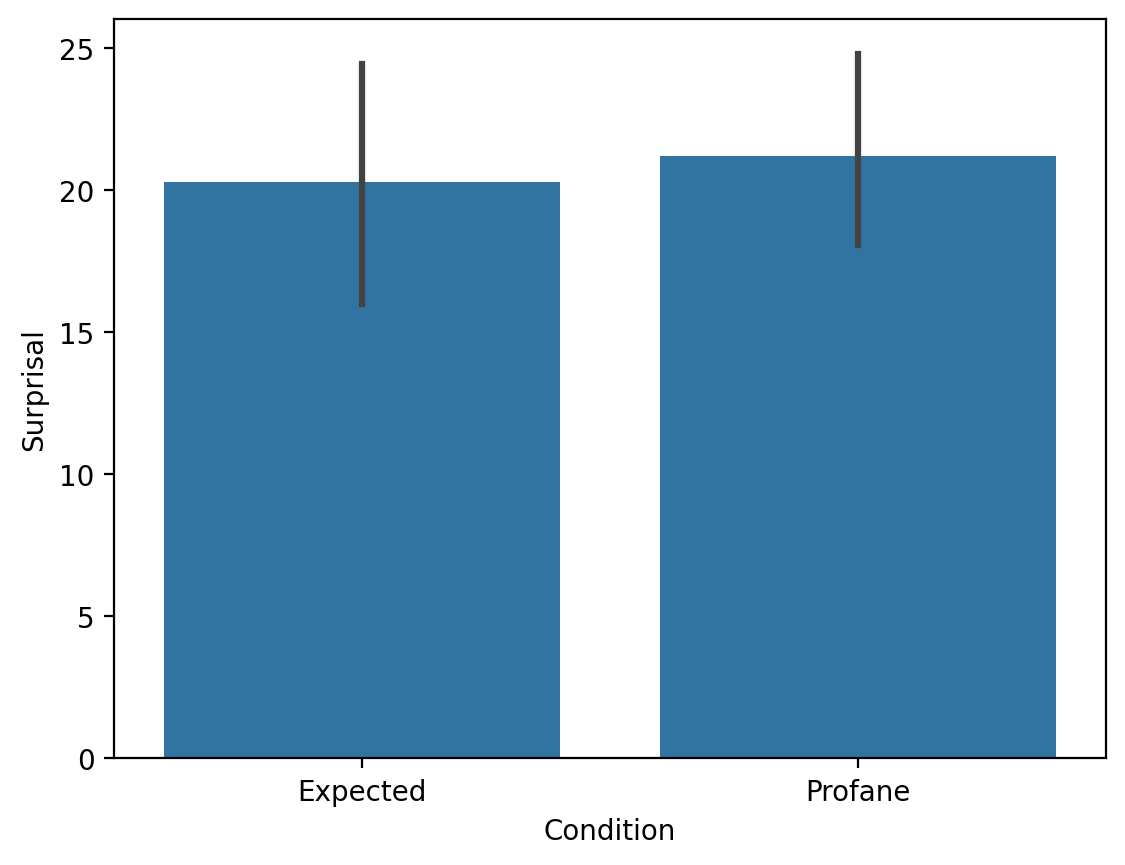

In [9]:
sns.barplot(data = df_results, x = "Condition", y = "Surprisal")

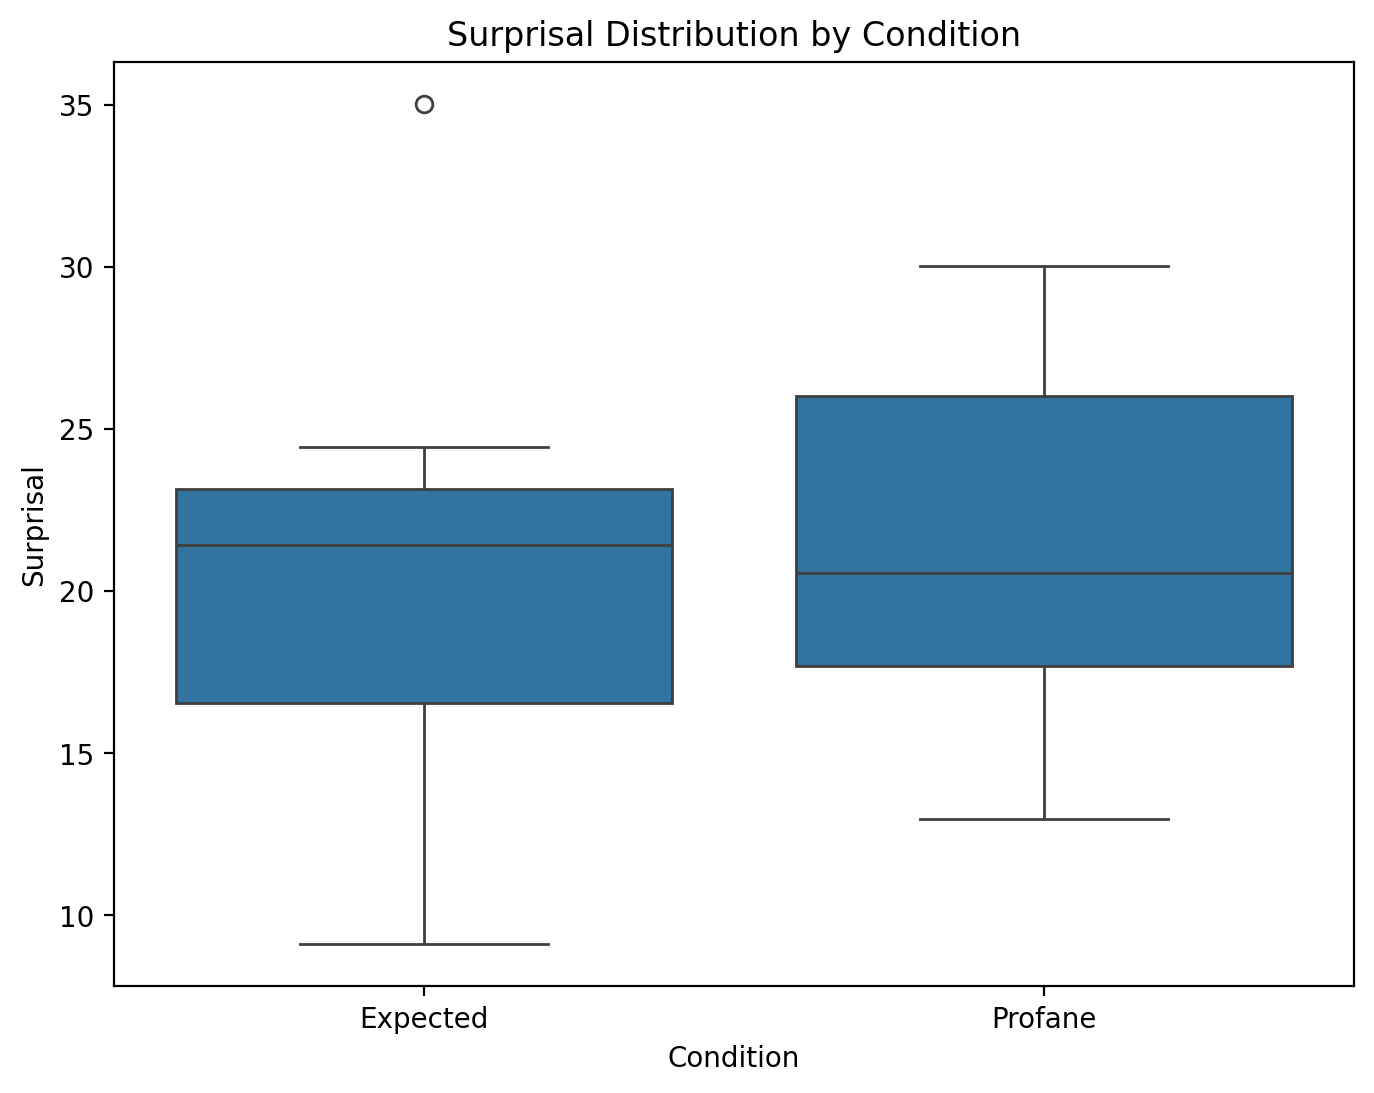

In [10]:
# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Surprisal', data=df_results)
plt.title('Surprisal Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Surprisal')
plt.show()


# **Method:**
For this final project, I wanted to focus on profanity and its relation and effects on LLMs such as GPT2. If there are any sort of filter on profane words or sensitive wording, then I hypothesized that the surprisal should be pretty different than the expected wording that does not contain profanity. If this is proven, then the discussion of how profanity is being filtered would be proven, which can be both good and bad in societal terms. To do this, I mainly used code lab 2 to calculate suprisals based on 10 pairs of stimuli, each pair containing a similar sentence but one with a profane ending, such as "Fuck" or "shit". Then I created a barplot as well as a box plot to visualize different that can be seen.

# **Discussion:**
Analysis of the visualization and results of calculating the surprisal were underwhelming in my opinion, as I was expecting a drastic difference in surprisal values, leaning toward a bigger surprisal difference. However, as the barplot displays, there is little to no differnce of the surprisal values of the expected word and the profane word, just with a slight difference. This shows that profane words do lead to sensitivity in LLMs, or proves to some extent that LLMs are not that sensistive to offensive language and profanity. The boxplot seems to have a little more difference, but in terms of the whole picture, there is little to no effect on sensitivity of profane words on LLMs. Potential confounds or issues with stimuli is that the prompt is confined to boundaries of having the specific word, profane or not at the end of the sentence, which may affect the surprisal value since profane words mostly come first in a sentence. Additionally, it was very hard to find exact counterparts of each profane words, as most would not make sense in regular sentences. Different types of profanity also come into play, since some are more american based, while others are more uk based slang, such as the term "bollocks". There should have been a better way to orient the stimuli in this case to compare sensitivity of profane language in LLMs, which should be an improvement made in future adaptations of this question of the sensitivity of profane words in LLMs. There are limitations to human cognition as well in this case, as profanity is commonly used outside of the internet as regular commentary, which may affect the sensitivity of LLMs. But in all, more research is needed in this area to properly conclude a point about the research question of: Are LLMs sensitive to offensive language and profanity?

#**Summary and further thoughts:**
In all, manipulating the stimuli to calculate surprisal regarding LLM sensitivity to offensive and profane language lead to findings that support that LLMs are not sensitive to these kinds of language. However, confounds and stimuli limitations are present that may have affected the results, which will be needed to be resolved and discussed further in future interpretations. Profanity is a big part of language itself, and research based on LLMs and profanity should be further discussed as a major point, as it may affect society itself when LLMs evolve and become a part of everyday life in the future.